# 单发多框检测（SSD）

我们在前几节分别介绍了边界框、锚框、多尺度目标检测和数据集，下面我们基于这些背景知识来构造一个目标检测模型：单发多框检测（single shot multibox detection，简称 SSD）[1]。它简单、快速，并得到了广泛使用。该模型的一些设计思想和实现细节常适用于其他目标检测模型。


## 模型

图 9.4 描述了 SSD 模型的设计。它主要由一个基础网络块和若干个多尺度特征块串联而成。其中基础网络块用来从原始图像抽取特征，一般会选择常用的深度卷积神经网络。SSD 论文中选用了在分类层之前截断的 VGG [1]，现在也常用 ResNet 替代。我们可以设计基础网络，使它输出的高和宽较大。这样一来，基于该特征图生成的锚框数量较多，可以用来检测尺寸较小的目标。接下来的每个多尺度特征块将上一层提供的特征图的高和宽缩小（例如减半），并使特征图中每个单元在输入图像上的感受野变得更广阔。如此一来，图 9.4 中越靠近顶部的多尺度特征块输出的特征图越小，基于特征图生成的锚框故而也越少，加之特征图中每个单元感受野越大，因此更适合检测尺寸较大的目标。由于 SSD 基于基础网络块和各个多尺度特征块生成不同数量和不同大小的锚框，并通过预测锚框的类别和偏移量（即预测边界框）检测不同大小的目标，因此 SSD 是一个多尺度的目标检测模型。

![SSD模型主要由一个基础网络块和若干多尺度特征块串联而成。](../img/ssd.svg)


接下来我们介绍如何实现图中的各个模块。我们先介绍如何实现类别预测和边界框预测。

### 类别预测层

设目标的类别个数为 $q$。每个锚框的类别个数将是 $q+1$，其中类别 0 表示锚框只包含背景。在某个尺度下，设特征图的高和宽分别为 $h$ 和 $w$，如果以其中每个单元为中心生成 $a$ 个锚框，那么我们需要对 $hwa$ 个锚框进行分类。如果使用全连接层作为输出，很容易导致模型参数过多。回忆[“网络中的网络（NiN）”](../chapter_convolutional-neural-networks/nin.md)一节介绍的使用卷积层的通道来输出类别预测的方法。SSD 采用同样的方法来降低模型复杂度。

具体来说，类别预测层使用一个保持输入高和宽的卷积层。这样一来，输出和输入在特征图宽和高上的空间坐标一一对应。考虑输出和输入同一空间坐标 $(x,y)$：输出特征图上 $(x,y)$ 坐标的通道里包含了以输入特征图 $(x,y)$ 坐标为中心生成的所有锚框的类别预测。因此输出通道数为 $a(q+1)$，其中索引为 $i(q+1) + j$（$0 \leq j \leq q$）的通道代表了索引为 $i$ 的锚框的类别索引为 $j$ 的预测。

下面我们定义一个这样的类别预测层。指定参数 $a$ 和 $q$ 后，它使用一个填充为 1 的 $3\times3$ 卷积层。该卷积层的输入和输出的高和宽保持不变。

In [1]:
%matplotlib inline
import gluonbook as gb
from mxnet import autograd, contrib, gluon, image, init, nd
from mxnet.gluon import loss as gloss, nn
import time

def cls_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), kernel_size=3,
                     padding=1)

### 边界框预测层

边界框预测层的设计与类别预测层的设计类似。唯一不同的是，这里需要为每个锚框预测 4 个偏移量，而不是 $q+1$ 个类别。

In [2]:
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, padding=1)

### 连结多尺度的预测

我们提到，SSD 根据多个尺度下的特征图生成锚框并预测类别和偏移量。由于每个尺度上特征图的形状或以同一单元为中心生成的锚框个数都可能不同，因此不同尺度的预测输出形状可能不同。

在下面的例子中，我们对同一批量数据构造两个不同尺度下的特征图`Y1`和`Y2`，其中`Y2`相对于`Y1`来说高和宽分别减半。以类别预测为例，假设以`Y1`和`Y2`特征图中每个单元生成的锚框个数分别是 5 和 3，当目标类别个数为 10 时，类别预测输出的通道数分别为 $5\times(10+1)=55$ 和 $3\times(10+1)=33$。预测输出的格式为（批量大小，通道数，高，宽）。可以看到，除了批量大小外，其他维度大小均不一样。我们需要将它们变形成统一的格式并将多尺度的预测连结，从而让后续计算更简单。

In [3]:
def forward(x, block):
    block.initialize()
    return block(x)

Y1 = forward(nd.zeros((2, 8, 20, 20)), cls_predictor(5, 10))
Y2 = forward(nd.zeros((2, 16, 10, 10)), cls_predictor(3, 10))
(Y1.shape, Y2.shape)

((2, 55, 20, 20), (2, 33, 10, 10))

通道维包含中心相同的锚框的预测结果。我们首先将通道维移到最后一维。因为不同尺度下批量大小仍保持不变，我们可以将预测结果转成二维的（批量大小，高 $\times$ 宽 $\times$ 通道数）的格式，以方便之后在维度 1 上的连结。

In [4]:
def flatten_pred(pred):
    return pred.transpose((0, 2, 3, 1)).flatten()

def concat_preds(preds):
    return nd.concat(*[flatten_pred(p) for p in preds], dim=1)

这样一来，尽管`Y1`和`Y2`形状不同，我们仍然可以将这两个同一批量不同尺度的预测结果连结在一起。

In [5]:
concat_preds([Y1, Y2]).shape

(2, 25300)

### 高和宽减半块

为了在多尺度检测目标，下面定义高和宽减半块`down_sample_blk`。它串联了两个填充为 1 的 $3\times3$ 卷积层和步幅为 2 的 $2\times2$ 最大池化层。我们知道，填充为 1 的 $3\times3$ 卷积层不改变特征图的形状，而后面的池化层直接将特征图的高和宽减半。由于 $1\times 2+(3-1)+(3-1)=6$，输出特征图中每个单元在输入特征图上的感受野形状为 $6\times6$。可以看出，高和宽减半块使得输出特征图中每个单元的感受野变得更广阔。

In [6]:
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels, kernel_size=3, padding=1),
                nn.BatchNorm(in_channels=num_channels),
                nn.Activation('relu'))
    blk.add(nn.MaxPool2D(2))
    return blk

测试高和宽减半块的前向计算。可以看到，它改变了输入的通道数，并将高和宽减半。

In [7]:
forward(nd.zeros((2, 3, 20, 20)), down_sample_blk(10)).shape

(2, 10, 10, 10)

### 基础网络块

基础网络块用来从原始图像抽取特征。为了计算简洁，我们在这里构造一个小的基础网络。该网络串联三个高和宽减半块，并逐步将通道数翻倍。当输入的原始图像的形状为 $256\times256$ 时，基础网络块输出的特征图的形状为 $32 \times 32$。

In [8]:
def base_net():
    blk = nn.Sequential()
    for num_filters in [16, 32, 64]:
        blk.add(down_sample_blk(num_filters))
    return blk

forward(nd.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

### 完整的模型

SSD 模型一共包含五个模块，每个模块输出的特征图既用来生成锚框，又用来预测这些锚框的类别和偏移量。第一模块为基础网络块，第二至第四模块为高和宽减半块，第五模块使用全局最大池化层将高和宽降到 1。因此第二至第五模块均为图 9.4 中的多尺度特征块。

In [9]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = nn.GlobalMaxPool2D()
    else:
        blk = down_sample_blk(128)
    return blk

接下来我们定义每个模块如何进行前向计算。跟之前介绍的卷积神经网络不同，这里不仅返回卷积计算输出的特征图`Y`，还返回根据`Y`生成的当前尺度的锚框，以及基于`Y`预测的锚框类别和偏移量。

In [10]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = contrib.ndarray.MultiBoxPrior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

我们提到，图 9.4 中较靠近顶部的多尺度特征块用来检测尺寸较大的目标，因此需要生成较大的锚框。我们在这里先将 0.2 到 1.05 之间均分五份，以确定不同尺度下锚框大小的较小值 0.2、0.37、0.54 等，再按 $\sqrt{0.2 \times 0.37} = 0.272$、$\sqrt{0.37 \times 0.54} = 0.447$ 等确定不同尺度下锚框大小的较大值。

In [11]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

现在，我们可以定义出完整的模型`TinySSD`了。

In [12]:
class TinySSD(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        for i in range(5):
            # 即赋值语句 self.blk_i = get_blk(i)。
            setattr(self, 'blk_%d' % i, get_blk(i))
            setattr(self, 'cls_%d' % i, cls_predictor(num_anchors,
                                                      num_classes))
            setattr(self, 'bbox_%d' % i, bbox_predictor(num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self, 'blk_%d' % i) 即访问 self.blk_i。
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, 'blk_%d' % i), sizes[i], ratios[i],
                getattr(self, 'cls_%d' % i), getattr(self, 'bbox_%d' % i))
        # reshape 函数中的 0 表示保持批量大小不变。
        return (nd.concat(*anchors, dim=1),
                concat_preds(cls_preds).reshape(
                    (0, -1, self.num_classes + 1)), concat_preds(bbox_preds))

我们创建 SSD 模型实例并对一个高和宽均为 256 像素的小批量图像`X`做前向计算。我们在之前验证过，第一模块输出的特征图的形状为 $32 \times 32$。由于第二至第四模块为高和宽减半块、第五模块为全局池化层，并且以特征图每个单元为中心生成 4 个锚框，每个图像在 5 个尺度下生成的锚框总数为 $(32^2 + 16^2 + 8^2 + 4^2 + 1)\times 4 = 5444$。

In [13]:
net = TinySSD(num_classes=1)
net.initialize()
X = nd.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: (1, 5444, 4)
output class preds: (32, 5444, 2)
output bbox preds: (32, 21776)


## 训练

下面我们描述如何一步步训练 SSD 模型来进行目标检测。

### 读取数据和初始化

我们读取之前构造的皮卡丘数据集。

In [14]:
batch_size = 32
train_data, test_data = gb.load_data_pikachu(batch_size)
# 为保证 GPU 计算效率，这里为每张训练图像填充了两个标签为 -1 的边界框。
train_data.reshape(label_shape=(3, 5))

在皮卡丘数据集中，目标的类别数为 1。定义好模型以后，我们需要初始化模型参数并定义优化算法。

In [15]:
ctx, net = gb.try_gpu(), TinySSD(num_classes=1)
net.initialize(init=init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'learning_rate': 0.2, 'wd': 5e-4})

### 定义损失和评价函数

目标检测有两个损失。一是有关锚框类别的损失。我们可以重用之前图像分类问题里一直使用的交叉熵损失函数。二是有关正类锚框偏移量的损失。预测偏移量是一个回归问题，但这里不使用前面介绍过的平方损失，而使用 $L_1$ 范数损失，即预测值与真实值之间差的绝对值。掩码变量`bbox_masks`令负类锚框和填充锚框不参与损失的计算。最后，我们将有关锚框类别和偏移量的损失相加得到模型的最终损失函数。

In [16]:
cls_loss = gloss.SoftmaxCrossEntropyLoss()
bbox_loss = gloss.L1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox

我们可以沿用准确率评价分类结果。因为使用了 $L_1$ 范数损失，我们用平均绝对误差评价边界框的预测结果。

In [17]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax 需要指定最后一维。
    return (cls_preds.argmax(axis=-1) == cls_labels).mean().asscalar()

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return ((bbox_labels - bbox_preds) * bbox_masks).abs().mean().asscalar()

### 训练模型

在训练模型时，我们需要在模型的前向计算过程中生成多尺度的锚框`anchors`，并为每个锚框预测类别`cls_preds`和偏移量`bbox_preds`。之后，我们根据标签信息`Y`为生成的每个锚框标注类别`cls_labels`和偏移量`bbox_labels`。最后，我们根据类别和偏移量的预测和标注值计算损失函数。为了代码简洁，这里没有评价测试数据集。

In [18]:
for epoch in range(20):
    acc, mae = 0, 0
    train_data.reset()  # 从头读取数据。
    start = time.time()
    for i, batch in enumerate(train_data):
        X = batch.data[0].as_in_context(ctx)
        Y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            # 生成多尺度的锚框，为每个锚框预测类别和偏移量。
            anchors, cls_preds, bbox_preds = net(X)
            # 为每个锚框标注类别和偏移量。
            bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(
                anchors, Y, cls_preds.transpose((0, 2, 1)))
            # 根据类别和偏移量的预测和标注值计算损失函数。
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                          bbox_masks)
        l.backward()
        trainer.step(batch_size)
        acc += cls_eval(cls_preds, cls_labels)
        mae += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
    if (epoch + 1) % 5 == 0:
        print('epoch %2d, class err %.2e, bbox mae %.2e, time %.1f sec' % (
            epoch + 1, 1 - acc / (i + 1), mae / (i + 1), time.time() - start))

epoch  5, class err 2.86e-03, bbox mae 3.08e-03, time 13.4 sec


epoch 10, class err 2.84e-03, bbox mae 2.85e-03, time 13.4 sec


epoch 15, class err 2.60e-03, bbox mae 2.71e-03, time 13.4 sec


epoch 20, class err 2.40e-03, bbox mae 2.47e-03, time 13.4 sec


## 预测

在预测阶段，我们希望能把图像里面所有感兴趣的目标检测出来。下面读取测试图像，将其变换尺寸，然后转成卷积层需要的四维格式。

In [19]:
img = image.imread('../img/pikachu.jpg')
feature = image.imresize(img, 256, 256).astype('float32')
X = feature.transpose((2, 0, 1)).expand_dims(axis=0)

我们通过`MultiBoxDetection`函数根据锚框及其预测偏移量得到预测边界框，并通过非极大值抑制移除相似的预测边界框。

In [20]:
def predict(X):
    anchors, cls_preds, bbox_preds = net(X.as_in_context(ctx))
    cls_probs = cls_preds.softmax().transpose((0, 2, 1))
    output = contrib.nd.MultiBoxDetection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0].asscalar() != -1]
    return output[0, idx]

output = predict(X)

最后，我们将置信度不低于 0.3 的边界框筛选为最终输出用以展示。

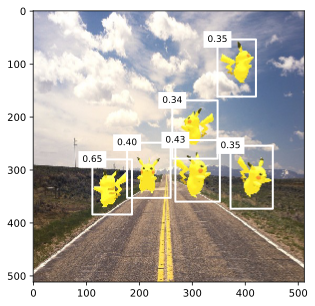

In [21]:
gb.set_figsize((5, 5))

def display(img, output, threshold):
    fig = gb.plt.imshow(img.asnumpy())
    for row in output:
        score = row[1].asscalar()
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * nd.array((w, h, w, h), ctx=row.context)]
        gb.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output, threshold=0.3)

## 小结

* SSD 是一个多尺度的目标检测模型。该模型基于基础网络块和各个多尺度特征块生成不同数量和不同大小的锚框，并通过预测锚框的类别和偏移量检测不同大小的目标。
* SSD 在训练中根据类别和偏移量的预测和标注值计算损失函数。



## 练习

* 限于篇幅原因，实验中忽略了 SSD 的一些实现细节。你能从以下几个方面进一步改进模型吗？


### 损失函数

将预测偏移量用到的 $L_1$ 范数损失替换为平滑 $L_1$ 范数损失。它在零点附近使用平方函数从而更加平滑：这是通过一个超参数 $\sigma$ 来控制平滑区域的：

$$
f(x) =
    \begin{cases}
    (\sigma x)^2/2,& \text{if }|x| < 1/\sigma^2\\
    |x|-0.5/\sigma^2,& \text{otherwise}
    \end{cases}
$$

当 $\sigma$ 很大时该损失类似于 $L_1$ 范数损失。当它较小时，损失函数较平滑。

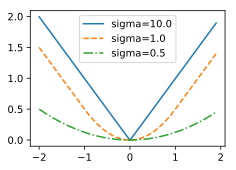

In [22]:
sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = nd.arange(-2, 2, 0.1)
gb.set_figsize()

for l, s in zip(lines, sigmas):
    y = nd.smooth_l1(x, scalar=s)
    gb.plt.plot(x.asnumpy(), y.asnumpy(), l, label='sigma=%.1f' % s)
gb.plt.legend();

在类别预测时，实验中使用了交叉熵损失：设真实类别 $j$ 的预测概率是 $p_j$，交叉熵损失为 $-\log p_j$。我们还可以使用焦点损失（focal loss）[2]：给定正的超参数 $\gamma$ 和 $\alpha$，该损失的定义为

$$ - \alpha (1-p_j)^{\gamma} \log p_j.$$

可以看到，增大 $\gamma$ 可以有效减小正类预测概率较大时的损失。

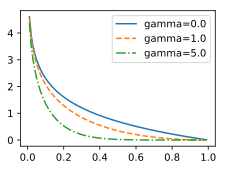

In [23]:
def focal_loss(gamma, x):
    return -(1 - x) ** gamma * x.log()

x = nd.arange(0.01, 1, 0.01)
for l, gamma in zip(lines, [0, 1, 5]):
    y = gb.plt.plot(x.asnumpy(), focal_loss(gamma, x).asnumpy(), l,
                    label='gamma=%.1f' % gamma)
gb.plt.legend();

### 训练和预测

* 当目标在图像中占比较小时，模型通常会采用比较大的输入图像尺寸。
* 为锚框标注类别时，通常会产生大量的负类锚框。我们可以对负类锚框采样，从而使数据类别更加平衡。这个可以通过设置`MultiBoxTarget`函数的`negative_mining_ratio`参数来完成。
* 在损失函数中为有关锚框类别和有关正类锚框偏移量的损失分别赋予不同的权重超参数。
* 参考 SSD 论文，还有哪些方法可以评价目标检测模型的精度 [1]？


## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/2511)

![](../img/qr_ssd.svg)

## 参考文献

[1] Liu, W., Anguelov, D., Erhan, D., Szegedy, C., Reed, S., Fu, C. Y., & Berg, A. C. (2016, October). Ssd: Single shot multibox detector. In European conference on computer vision (pp. 21-37). Springer, Cham.

[2] Lin, T. Y., Goyal, P., Girshick, R., He, K., & Doll á r, P. (2018). Focal loss for dense object detection. IEEE transactions on pattern analysis and machine intelligence.